### Evaluating a Linear Regression Model for Predicting a State's Breweries Per Capita

With the growth of craft beer has come a growth in new breweries. The number of breweries in the US have increased +286% in just the past 10 years (2016 vs 2006) and +410% in the past 20 years. The growth doesn't seem to be slowing down either, with 2016 up +18% in the number of breweries in the US compared to 2015.

In this notebook I'll use the data I've collected in a linear regression model to see if it is a good predictor of the number of breweries a state has.

To account for the different populations for each state, I'll be using breweries per capita (per 100K adults) as the dependent variable. The independent variables I've collected to try and predict the breweries per capita (BPC) by state include age, race, median hhi, craft gallons consumed per adult and barrels of craft beer produced.

As a reminder, the age and race data is in percentages, the median hhi data is in full dollar amounts, craft gallons per adult is the average per adult and breweries per capita (BPC) is the average per 100K adults

In this notebook:
1. Exploratory data anlaysis

2. Feature selection
    
3. Additional data prep
    
4. Linear regression model

5. Conclusion and next steps

In [67]:
import pandas as pd
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

f = open('brew_data_prepped.csv', 'r')
df = pd.read_csv(f)
df = df.drop(df.columns[0], axis=1)
          
df.head()

,Location,kids_0_18,adults_19_25,adults_26_34,adults_35_54,adults_55_64,adults_over_65,white,black,hispanic,asian,amer_ind_ak,nat_haw_pac_is,two_or_more_r,median_hhi,craft_barr_produced,craft_gal_per_adult,b_per_capita
0,AK,0.283,0.095,0.152,0.233,0.119,0.118,0.598,0.028,0.066,0.050,0.166,0.022,0.069,75723.000,207369.000,12.500,7.069
1,AL,0.239,0.093,0.112,0.258,0.141,0.157,0.673,0.274,0.041,0.000,0.000,0.000,0.012,47221.000,61042.000,0.500,1.006
2,AR,0.252,0.092,0.118,0.252,0.123,0.164,0.740,0.158,0.072,0.000,0.008,0.000,0.022,45907.000,35846.000,0.500,1.543
3,AZ,0.249,0.102,0.108,0.256,0.124,0.162,0.544,0.045,0.347,0.033,0.020,0.000,0.012,57100.000,147255.000,0.900,2.126
4,CA,0.247,0.098,0.129,0.265,0.123,0.138,0.379,0.054,0.386,0.148,0.005,0.006,0.022,66637.000,3295221.000,3.700,3.141


Descriptive statistics for age by state

In [68]:
df.iloc[:, 1:7].describe()

,kids_0_18,adults_19_25,adults_26_34,adults_35_54,adults_55_64,adults_over_65
count,51.000,51.000,51.000,51.000,51.000,51.000
mean,0.243,0.092,0.123,0.252,0.132,0.157
std,0.023,0.007,0.018,0.012,0.013,0.017
min,0.186,0.077,0.097,0.221,0.092,0.112
25%,0.228,0.088,0.113,0.245,0.126,0.148
50%,0.243,0.092,0.121,0.254,0.133,0.157
75%,0.256,0.096,0.128,0.258,0.139,0.168
max,0.313,0.116,0.220,0.283,0.161,0.191


Descriptive statistics for the rest

In [69]:
df.iloc[:, 7:].describe()

,white,black,hispanic,asian,amer_ind_ak,nat_haw_pac_is,two_or_more_r,median_hhi,craft_barr_produced,craft_gal_per_adult,b_per_capita
count,51.000,51.000,51.000,51.000,51.000,51.000,51.000,51.000,51.000,51.000,51.000
mean,0.694,0.110,0.122,0.040,0.007,0.004,0.022,59179.000,481690.745,3.567,3.756
std,0.166,0.106,0.106,0.059,0.026,0.024,0.021,9062.874,760301.884,4.171,2.948
min,0.192,0.007,0.010,0.000,0.000,0.000,0.000,41099.000,10029.000,0.300,0.642
25%,0.587,0.032,0.052,0.011,0.000,0.000,0.013,53874.500,56935.000,0.950,1.890
50%,0.719,0.075,0.099,0.027,0.000,0.000,0.020,58046.000,207369.000,1.900,2.720
75%,0.808,0.146,0.146,0.046,0.000,0.000,0.025,66544.000,538342.500,3.750,4.518
max,0.955,0.459,0.533,0.387,0.166,0.171,0.138,76260.000,3905620.000,19.800,14.862


BPC by state in 2016 bar graph

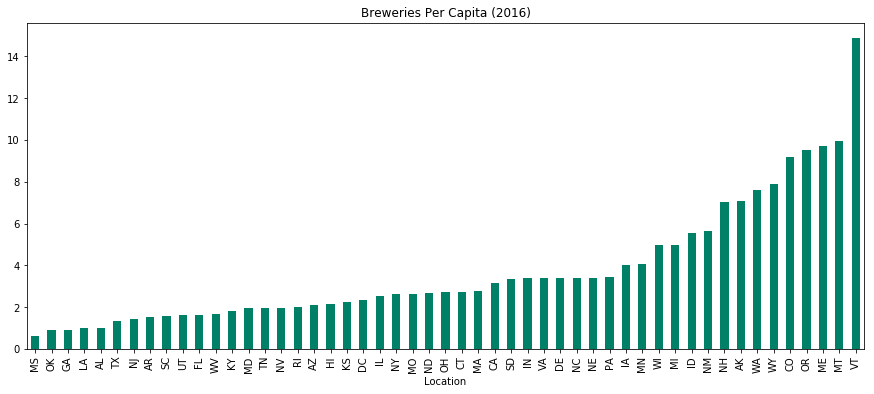

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

tot_brew_state = df.groupby('Location')['b_per_capita'].sum().sort_values()
tot_brew_state.plot(figsize = (15, 6), kind='bar', colormap = 'summer', title='Breweries Per Capita (2016)')
plt.margins(x=0)

Geographic distribution of BPC 

In [71]:
import plotly as py
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

data = [ dict(type='choropleth', autocolorscale = True, locations = df['Location'],
        z = df['b_per_capita'].astype(float), locationmode = 'USA-states',
        marker = dict (line = dict (color = 'white', width = 1)),
        colorbar = dict (title = 'Breweries Per Capita')
        ) ]

layout = dict(title = 'Breweries Per Capita (2016)',
        geo = dict(scope='usa',projection=dict(type='albers usa' ),showlakes = False),
             )
    
fig = dict(data=data, layout=layout )
py.offline.iplot(fig)

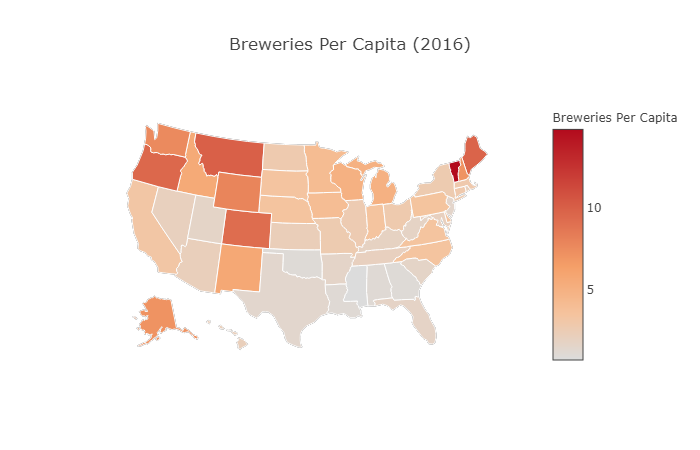

In [83]:
#Including an image so it can display in a static html
from IPython.display import Image
Image('bpc_by_state_map.png')

The states with the highest BPC in 2016 are concentrated in northern New England,
 the Pacific Northwest + Alaska, and some western/southwestern states

The states with the lowest BPC are in the south

Histogram and boxplot of BPC by state

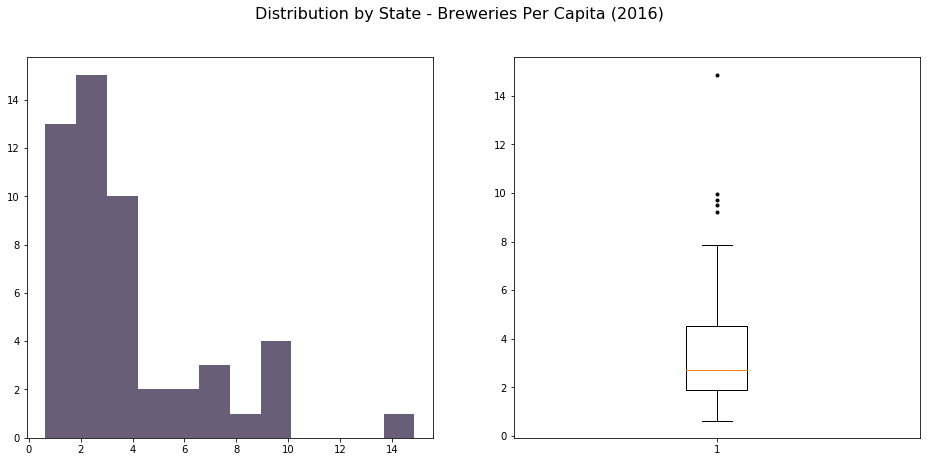

In [72]:
x = df['b_per_capita']
fig, axs = plt.subplots(1, 2, figsize=(16,7))
plt.suptitle('Distribution by State - Breweries Per Capita (2016)', fontsize=16)
axs[0].hist(x, bins=12, color="#685e77")
axs[1].boxplot(x,notch=0, whis=1.5, sym='k.')
plt.margins(x=0)

The distribution of BPC has a long right tail with the median closer to the first quartile

Vermont is the outlier here. I know it's not a data entry mistake and it's not too extrreme so I'll leave it in

Looking to see which independent  variables are correlated with our dependent variable of BPC

In [73]:
corr = df.corr()
corr['b_per_capita'].sort_values(ascending = False)

b_per_capita           1.000
craft_gal_per_adult    0.746
white                  0.429
adults_55_64           0.324
adults_over_65         0.267
median_hhi             0.243
two_or_more_r          0.148
adults_35_54           0.076
craft_barr_produced    0.070
amer_ind_ak            0.048
nat_haw_pac_is        -0.058
asian                 -0.126
hispanic              -0.127
adults_19_25          -0.187
adults_26_34          -0.197
kids_0_18             -0.218
black                 -0.503
Name: b_per_capita, dtype: float64

Craft gallons consumed per adult has the highest correlation with breweries per capita. This really shows how much the growth of breweries in this country is due to the growth in craft beer. Not terribly surprising but interesting nonetheless.

Surprisingly, the number of barrels of craft beer produced isn't correlated with BPC at all.  A barrel is equal to 31.5 us gallons. Not shown here but Pennsylvania is the leader at 3.9MM bbls produced in 2016 but only 16th for BPC. The main reason for this is that the Breweries Association classifies Yeungling (which is in PA) as a craft brewery. In 2012, they produced 2.8MM bbls alone and most would not consider them as a craft brewery. For our purposes we won't be using that metric since the classification isn't great.

The variables of 'white', 'A55-64' and 'hhi' are the next strongest positive predictors of the BPC for a state so we'll
concentrate on those along with craft gallons consumed.

In terms of race, 'black' also has a strong negative correlation to BPC it's also most likely correlated with 'white' so we wouldn't want to include both as independent variables. We'll check for collinearity next and if that's the case we'll try both separately in our model to see which works best.

Now that I have some independent variables I'll check them for collinearity

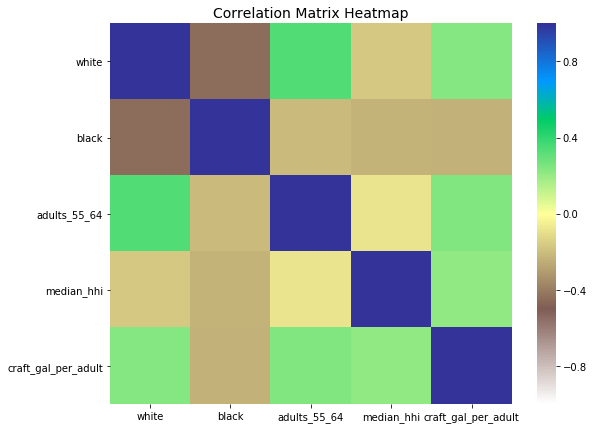

In [74]:
import seaborn as sns
df_select = df[['white', 'black', 'adults_55_64', 'median_hhi', 'craft_gal_per_adult']].corr()
tick = df_select.columns.values
fig, axs = plt.subplots(figsize=(9, 7))
sns.heatmap(df_select, xticklabels=tick, yticklabels=tick, cmap ='terrain_r', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap', fontsize=14)
plt.margins(x=0)

In [75]:
df[['white', 'black', 'adults_55_64', 'median_hhi', 'craft_gal_per_adult']].corr()

,white,black,adults_55_64,median_hhi,craft_gal_per_adult
white,1.000,-0.446,0.340,-0.165,0.237
black,-0.446,1.000,-0.204,-0.228,-0.242
adults_55_64,0.340,-0.204,1.000,-0.083,0.247
median_hhi,-0.165,-0.228,-0.083,1.000,0.211
craft_gal_per_adult,0.237,-0.242,0.247,0.211,1.000


'white' and 'black' are highly correlated with each other so we'll choose only one to include in our model. I'll define two sets of dependent variables, one with 'white' and one whith 'black'. I'll use cross validation to select the best one and then split the data into a training and test set.

Vizualizing the linear relationship between BPC and the dependent variables

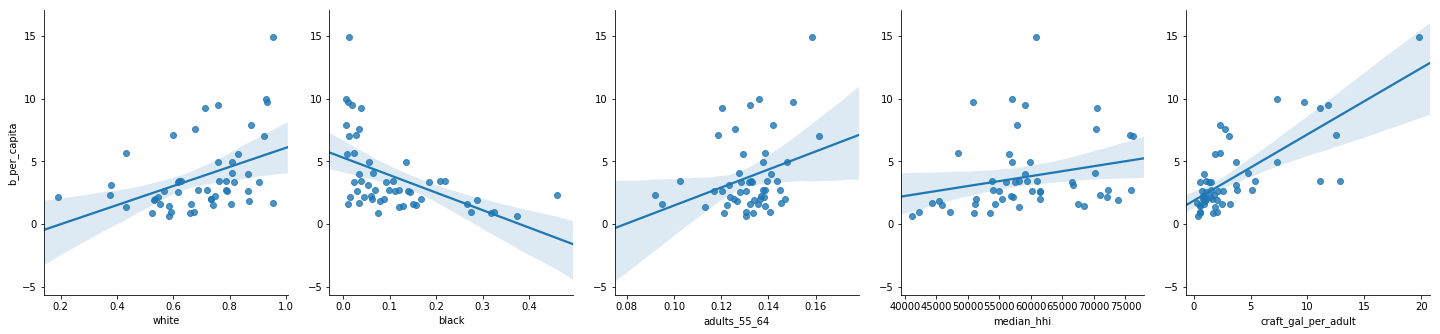

In [76]:
sns.pairplot(df, x_vars=['white', 'black', 'adults_55_64', 'median_hhi', 'craft_gal_per_adult'], y_vars=["b_per_capita"], 
             kind = 'reg', size=4.75, aspect=.85)
plt.margins(x=0)

For the most part, the independent variables have a linear relationship with BPC.

At this point, I'm ready to split the data into training and testing sets. We'll do three different groups of independent variables and then use the average of 10 cross validation scores to select the best combo.

In [77]:
from sklearn.model_selection import train_test_split

X = df[['white', 'adults_55_64', 'median_hhi', 'craft_gal_per_adult']]
X2 = df[['black', 'adults_55_64', 'median_hhi', 'craft_gal_per_adult']]
X3 = df[['white', 'median_hhi', 'craft_gal_per_adult']]
y = df['b_per_capita']

X_train_w, X_test_w, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_b, X_test_b, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=42)
X_train_a, X_test_a, y_train, y_test = train_test_split(X3, y, test_size=0.25, random_state=42)

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np

lin = linear_model.LinearRegression()

score_w = np.sqrt(-cross_val_score(lin, X_train_w, y_train, cv=10, scoring = 'neg_mean_squared_error')).mean()
score_b = np.sqrt(-cross_val_score(lin, X_train_b, y_train, cv=10, scoring = 'neg_mean_squared_error')).mean()
score_a = np.sqrt(-cross_val_score(lin, X_train_a, y_train, cv=10, scoring = 'neg_mean_squared_error')).mean()

print('with white:                      ', score_w)
print('with black:                      ', score_b)
print('with white and without age_55_64:', score_a)

with white:                       1.91894736467
with black:                       2.07259049738
with white and without age_55_64: 1.82840069964


The score for the set of dependent variables with 'black' was higher and thus performed worse than the set with
'white' so we'll use that feature instead.

I'll fit a linear regression model to our training data now to see how it performs using RMSE, adjusted r-squared and r-squared. Before that though I need scale the dependent variables since they have much different ranges for the values. I'll remove the mean and scale to a unit variance on the training data now and on the test data later.

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit_transform(X_train_w[:5]))

[[ 0.84363739  1.96015111  1.29788622 -0.28349087]
 [ 0.77157044 -0.24500557  0.69453069  0.71706515]
 [-1.76439859 -0.56174665  0.29971065  1.55086183]
 [ 0.60785127 -0.81862517 -1.387277   -1.11728755]
 [-0.45866052 -0.33477373 -0.90485056 -0.86714855]]


In [80]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score

def adj_r2_score(model, y, yhat):
        adj = 1 - float(len(y)-1)/(len(y)-len(model.coef_)-1)*(1 - metrics.r2_score(y,yhat))
        return adj

lin_model_train = lin.fit(X_train_a, y_train)
bpc_predict_train = lin.predict(X_train_a)
lin_mse_train = mean_squared_error(y_train, bpc_predict_train)
lin_rmse_train = np.sqrt(lin_mse_train)

print("Train RMSE:  ", lin_rmse_train)
print('Train r2:    ', r2_score(y_train, bpc_predict_train))
print("Train Adj r2:", adj_r2_score(lin, y_train, bpc_predict_train))

Train RMSE:   1.67330078593
Train r2:     0.59811198324
Train Adj r2: 0.562651275879


In [81]:
scaler.fit_transform(X_test_a) #Scaling the training data

lin_model_test = lin.fit(X_test_a, y_test)
bpc_predict_test = lin.predict(X_test_a)
lin_mse_test = mean_squared_error(y_test, bpc_predict_test)
lin_rmse_test = np.sqrt(lin_mse_test)

print('Test RMSE:  ', lin_rmse_test)
print('Test r2:    ', r2_score(y_test, bpc_predict_test))
print("Test Adj r2:", adj_r2_score(lin, y_test, bpc_predict_test))

Test RMSE:   1.86381720103
Test r2:     0.730762121353
Test Adj r2: 0.641016161804


For the training data we had an adjusted r-squared of .56, meaning 56% of the variance of BPC can be explained by our model.

The testing data actually performed a little better in terms of adjusted r-squared at 64% but a little worse for RMSE which was higher at 1.86 compared to 1.67. 

### Conclusions:
Our linear model needs some work. An adjusted r-squared of 56% on the training data isn't great. We can try a few things to improve this as next steps:

1. Try and see how stratifying our sample does for the training and testing data. We have a small set of observations at 51 and given the fact that the testing data actually performed better than the training data means that the two samples are not the same
2. Increase the number of observations. Including additional years would give us more data
3. Try additional independent variables. We could have some underfitting going on as well so trying out some different kinds of independent variables would also be a good idea
4. Try and take the log of the independent variable to approximate a more normal distribution. The histogram and boxplot showed that the it had a long right tail
5. Try different models